# 8장 합성곱 신경망: 컴퓨터 비전

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 8장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**구글 코랩 설정**

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [6]:
import tensorflow as tf
tf.__version__

'2.17.0'

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**참고**

아래 코드에 대한 자세한 설명은
[컴퓨터 비전 기초: 합성곱 신경망](https://codingalzi.github.io/dlp2/computer_vision_intro.html)를 
참고한다.

## 8.1 합성곱 신경망 소개

**예제: MNIST 데이터셋 분류 CNN 모델**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# 입력층
inputs = keras.Input(shape=(28, 28, 1))

# 은닉층
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x) # 1차원 텐서로 변환

# 출력층
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

**모델 구성 요약**

In [5]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

**MNIST 이미지 분류 훈련**

모델 훈련은 이전과 동일하다.

- 훈련셋 준비

In [11]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

- 모델 컴파일과 훈련

In [12]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5


I0000 00:00:1731495193.781843    8943 service.cc:146] XLA service 0x7f8ed00053b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731495193.781916    8943 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4000 Laptop GPU, Compute Capability 8.6


 81/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5871 - loss: 1.2413

I0000 00:00:1731495195.907691    8943 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8831 - loss: 0.3626
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9855 - loss: 0.0449
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9905 - loss: 0.0298
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9930 - loss: 0.0234
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9955 - loss: 0.0169


**훈련된 CNN 평가**

테스트셋에 대한 성능이 이전에 사용한 `Sequential` 모델보다 훨씬 좋다.

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도: {test_acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9894 - loss: 0.0410
테스트 정확도: 0.991


### 8.1.1. 합성곱 연산

### 8.1.2. 맥스 풀링 연산

아래 코드는 맥스 풀링 층을 사용하지 않는 경우 가중치 파라미터의 수가 엄청나게 증가함을 잘 보여준다. 

- 맥스 풀링 사용하는 경우: 104,202개
- 그렇지 않은 경우: 712,202개

In [14]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model_no_max_pool.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │       619,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,202 (2.72 MB)

 Trainable params: 712,202 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

## 8.2 합성곱 신경망 실전 활용 예제

### 8.2.1. 작은 데이터셋과 딥러닝 모델

### 8.2.2. 데이터 다운로드

훈련에 필요한 데이터를 다운로드한다.
하지만 이어지는 데이터 다운로드 관련 코드의 실행은 주의를 기울여야 한다.

- 캐글(kaggle) 계정을 갖고 있어야 하며, 로그인된 상태에서 아래 두 과정을 먼저 해결해야 한다.
- 캐글에 로그인한 후 "Account" 페이지의 계정 설정 창에 있는 "API" 항목에서
    "Create New API Token"을 생성하여 다운로드한다.
- [캐글: Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/rules)를
    방문해서 "I Understand and Accept" 버튼을 클릭해야 한다.

이어지는 데이터셋 다운로드 관련 코드 중 1단계와 2단계는 구글 코랩에서 실행하는 것을 가정한다.
만약 개인 PC에서 실행하고자 할 경우 다음 사항들을 고려한 다음 3단계부터 실행하면 된다.

- `kaggle.json`: kaggle의 사용자 계정으로 데이터셋을 다운로드하는 데 사용된다. kaggle 웹사이트에 로그인한 후
    "My Account"의 API 섹션에서 하나 생성한 후 다운로드한다.

- 사용자 홈디렉토리에 `.kaggle` 이라는 디렉토리를 생성한 후에 다운로드한 `kaggle.json` 파일을 저장한다.
    이 세팅은 한 번만 진행하면 되며, 사용자의 홈디렉토리를 확인하는 방법은 다음과 같다.

- `kaggle.json` 파일을 홈디렉토리의 `.kaggle` 디렉토리에 저장한 다음에 다음 명렬문을 실행한다.\
    아래 명령문은 보안을 위해 `kaggle.json` 파일을 읽기 전용으로 지정한다.

    ```python
    !chmod 600 ~/.kaggle/kaggle.json
    ```
    
- 3단계를 실행하려면 pip을 이용하여 `kaggle` API가 설치되어 있어야 한다. 
    아직 설치하지 않았다면 주피터 노트북에서 아래 명령문을 실행하면 된다.

    ```python
    !pip install kaggle
    ```

- `kaggle` API를 굳이 설치하지 않으려면 
    [캐글: Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)에서
    `train.zip` 파일을 다운로드하여 현재 주피터 노트북이 실행되는 디렉토리에 저장한 후에
    4단계부터 실행하면 된다.

- 다운로드 1단계 (구글 코랩에서만 사용)

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('구글 코랩 사용중!')
    from google.colab import files
    files.upload()

이어지는 코드는 kaggle.json 파일이 현재 디렉토리에 있다고 가정한다. 
개인 피씨에서 현재 주피터 노트북을 실행하는 경우엔
`~/.kaggle` 디렉토리에 `kaggle.json` 파일이 저장되어 있도록 해야 한다.

- 다운로드 2단계 (구글 코랩에서만 사용): kaggle.json 파일이 현재 워킹 디렉토리에 있다고 가정한 상태에서 아래 명령문 실행.

In [11]:
import os, shutil, pathlib

# kaggle 인증서 현재 저장 위치
where_kaggle_json = pathlib.Path("kaggle.json")

# kaggle 인증서를 사용자 홈디렉토리의 ".kaggle/" 디렉토리로 옮기기
if where_kaggle_json.is_file():
    # 홈디렉토리 경로 지정
    homeDir = pathlib.Path.home()
    kaggleDir = homeDir / ".kaggle"
    kaggleJsonFile = kaggleDir / "kaggle.json"

    # ".kaggle" 디렉토리 존재 여부 확인. 없으면 생성.
    if not kaggleDir.is_dir():
        os.makedirs(kaggleDir)

    # "kaggle.json" 파일 존재 여부 확인. 없으면 복사.
    if not kaggleJsonFile.is_file():
        shutil.copyfile(src=where_kaggle_json, 
                        dst=kaggleJsonFile)
        os.chmod(kaggleJsonFile, 0o600)
else:
    print("kaggle.json 파일을 지정된 사용자 홈폴더의 '.kaggle' 폴더에 저장하세요!")

- 다운로드 3단계: 강아지-고양이 이미지셋 다운로드

In [13]:
# 강아지-고양이 이미지셋 다운로드 및 압축 해제
try: 
    !kaggle competitions download -c dogs-vs-cats
except: 
    !pip install kaggle
    !kaggle competitions download -c dogs-vs-cats

100%|███████████████████████████████████████▊| 809M/812M [00:28<00:00, 33.5MB/s]
100%|████████████████████████████████████████| 812M/812M [00:28<00:00, 30.2MB/s]


- 다운로드 4단계: 압축 풀기

In [14]:
import zipfile

try:
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
except:
    with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

**훈련셋, 검증셋, 테스트셋 준비**

25,000 장의 사진 중에서 총 5,000 장의 사진만 사용해서 합성곱 신경을 훈련시키려 한다.

- 훈련셋: 강아지와 고양이 각각 1,000 장
- 검증셋: 강아지와 고양이 각각 500 장
- 테스트셋: 강아지와 고양이 각각 1,000 장

아래 코드는 앞서 지정한 대로 총 5,000 장의 사진으로 이루어진 데이터셋을
추출해서 각각의 디렉토리에 저장한다.
디렉토리의 구성은 다음과 같다.

```
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```

In [15]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### 8.2.3. 모델 구성

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# 입력층
inputs = keras.Input(shape=(180, 180, 3))

# 은닉층
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

강아지와 고양이의 비율이 동일하기에 정확도를 평가지표로 사용한다.

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 8.2.4. 데이터 전처리와 모델 훈련

**데이터 전처리**

샘플 사진의 크기가 제 각각이기에 모델의 입력값으로 지정된 크기인 `(180, 180, 3)` 모양의 
텐서로 변환을 해주어야 한다.
케라스의 `image_dataset_from_directory()` 함수를 이용하면 변환 뿐만 아니라
지정된 배치 크기의 배치로 구성된 훈련셋, 검증셋, 테스트셋을 쉽게 생성할 수 있다.

In [19]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


생성된 `train_dataset`, `validation_dataset`, `test_dataset`은 모두
`BatchDataset` 클래스의 객체이다.

**생성된 데이터셋 항목 확인**

In [20]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**모델 훈련**

`ModelCheckpoint` 콜백을 이용하여 검증셋에 대한 손실값(`"val_loss"`)을
기준으로 최고 성능의 모델을 저장한다.

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.4995INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 24s 323ms/step - loss: 0.6980 - accuracy: 0.4995 - val_loss: 0.6921 - val_accuracy: 0.5090
Epoch 2/30
62/63 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5408INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 6s 84ms/step - loss: 0.6936 - accuracy: 0.5410 - val_loss: 0.6840 - val_accuracy: 0.6020
Epoch 3/30
61/63 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.5815INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 5s 80ms/step - loss: 0.6823 - accuracy: 0.5850 - val_loss: 0.6582 - val_accuracy: 0.6030
Epoch 4/30
61/63 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.6358INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 5s 80ms/step - loss: 0.6447 - accuracy: 0.6385 - val_loss: 0.6495 - val_accuracy: 0.6160
Epoch 5/30
61/63 [============================>.] - ETA: 0s - loss: 0.6172 - accuracy: 0.6578INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 5s 81ms/step - loss: 0.6155 - accuracy: 0.6605 - val_loss: 0.6092 - val_accuracy: 0.6500
Epoch 6/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6068 - accuracy: 0.6815 - val_loss: 0.6406 - val_accuracy: 0.6140
Epoch 7/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5611 - accuracy: 0.7045 - val_loss: 0.6694 - val_accuracy: 0.6220
Epoch 8/30
61/63 [============================>.] - ETA: 0s - loss: 0.5389 - accuracy: 0.7208INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 6s 83ms/step - loss: 0.5408 - accuracy: 0.7205 - val_loss: 0.5829 - val_accuracy: 0.6920
Epoch 9/30
63/63 [==============================] - 4s 65ms/step - loss: 0.5020 - accuracy: 0.7620 - val_loss: 0.5990 - val_accuracy: 0.6730
Epoch 10/30
61/63 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.7782INFO:tensorflow:Assets written to: convnet_from_scratch/assets


INFO:tensorflow:Assets written to: convnet_from_scratch/assets


63/63 [==============================] - 6s 83ms/step - loss: 0.4660 - accuracy: 0.7780 - val_loss: 0.5759 - val_accuracy: 0.7130
Epoch 11/30
63/63 [==============================] - 5s 67ms/step - loss: 0.4266 - accuracy: 0.8060 - val_loss: 0.6675 - val_accuracy: 0.7030
Epoch 12/30
63/63 [==============================] - 4s 64ms/step - loss: 0.4245 - accuracy: 0.8160 - val_loss: 0.6524 - val_accuracy: 0.7070
Epoch 13/30
63/63 [==============================] - 4s 63ms/step - loss: 0.3233 - accuracy: 0.8560 - val_loss: 0.7632 - val_accuracy: 0.7150
Epoch 14/30
63/63 [==============================] - 4s 64ms/step - loss: 0.2830 - accuracy: 0.8775 - val_loss: 0.6526 - val_accuracy: 0.7440
Epoch 15/30
63/63 [==============================] - 4s 64ms/step - loss: 0.2478 - accuracy: 0.8975 - val_loss: 0.6894 - val_accuracy: 0.7030
Epoch 16/30
63/63 [==============================] - 4s 64ms/step - loss: 0.1934 - accuracy: 0.9250 - val_loss: 0.8311 - val_accuracy: 0.7310
Epoch 17/30
63/63 

과대 적합이 10번 정도의 에포크 이후에 빠르게 발생한다.

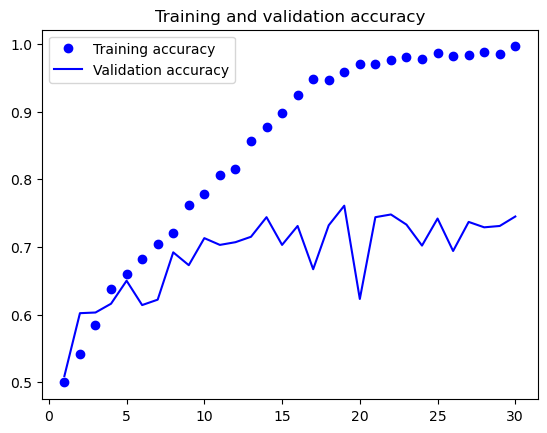

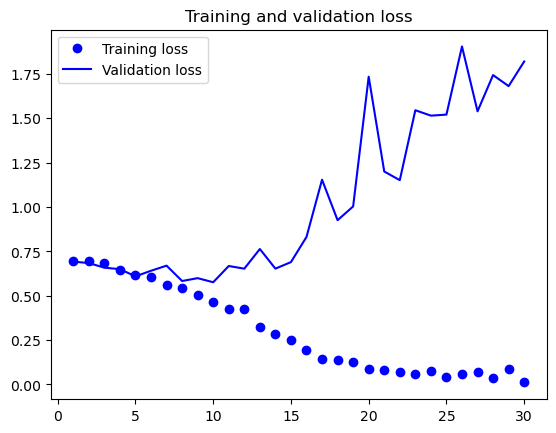

In [22]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

훈련된 최고 성능의 모델에 대한 테스트셋에 대한 정확도가 70% 정도의 정확도로 그렇게 높지 않다.
과대적합이 매우 빠르게 발생했기 때문인데 이는 훈련셋의 크기가 2,000 정도로 너무 작기 때문이다.

In [23]:
# 최선 모델 적재
test_model = keras.models.load_model("convnet_from_scratch")

# 테스트 결과
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 38ms/step - loss: 0.6073 - accuracy: 0.6955
Test accuracy: 0.696


### 8.2.5. 데이터 증식

아래 코드는 Sequential 모델을 이용하여 간단하게 데이터 증식 층을 구현한다.

- `RandomFlip()`: 사진을 50%의 확률로 지정된 방향으로 회전. 
- `RandomRotation()`: 사진을 지정된 범위 안에서 임의로 좌우로 회전
- `RandomZoom()`: 사진을 지정된 범위 안에서 임의로 확대 및 축소

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

훈련셋의 첫째 이미지를 대상으로 데이터 증식 층을 아홉 번 적용한 결과를 
다음고 같다. 실행결과가 다를 수 있음에 주의하라.

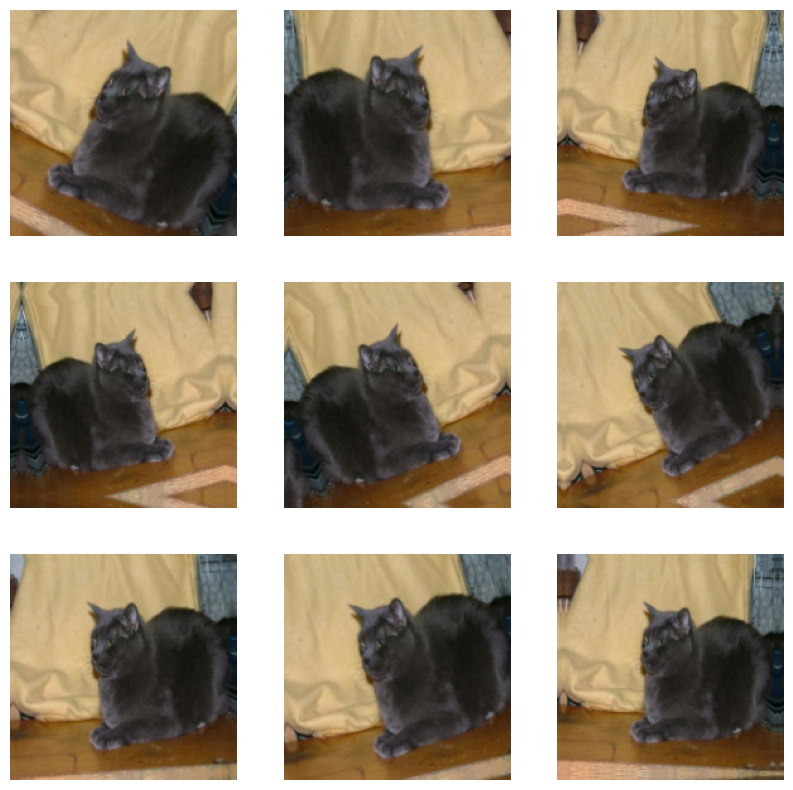

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

데이터 증식 층을 이용하여 모델 구성을 다시 한다. 
과대적합을 최대한 방지하기 위해 출력층 바로 이전에 드롭아웃(Dropout) 층도 추가한다.

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

모델 훈련은 동일하다. 다만 에포크 수를 100으로 늘린다.
이유는 과대적합이 보다 늦게 발생할 것이기 때문이다.

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.5020INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 96ms/step - loss: 0.7428 - accuracy: 0.5020 - val_loss: 0.6930 - val_accuracy: 0.5010
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.5135INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 92ms/step - loss: 0.6958 - accuracy: 0.5135 - val_loss: 0.6927 - val_accuracy: 0.5020
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5005INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 97ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5230
Epoch 4/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6946 - accuracy: 0.5230 - val_loss: 0.9530 - val_accuracy: 0.5000
Epoch 5/100
62/63 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.5504INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 98ms/step - loss: 0.6914 - accuracy: 0.5505 - val_loss: 0.6893 - val_accuracy: 0.5400
Epoch 6/100
62/63 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5751INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 103ms/step - loss: 0.6867 - accuracy: 0.5740 - val_loss: 0.6698 - val_accuracy: 0.6140
Epoch 7/100
62/63 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.5963INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 100ms/step - loss: 0.6707 - accuracy: 0.5960 - val_loss: 0.6559 - val_accuracy: 0.5690
Epoch 8/100
63/63 [==============================] - 5s 66ms/step - loss: 0.6463 - accuracy: 0.6485 - val_loss: 0.6632 - val_accuracy: 0.5850
Epoch 9/100
63/63 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.6720INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 95ms/step - loss: 0.6144 - accuracy: 0.6720 - val_loss: 0.5906 - val_accuracy: 0.6690
Epoch 10/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6185 - accuracy: 0.6745 - val_loss: 0.6316 - val_accuracy: 0.6260
Epoch 11/100
63/63 [==============================] - 4s 64ms/step - loss: 0.5837 - accuracy: 0.7035 - val_loss: 0.6205 - val_accuracy: 0.6670
Epoch 12/100
62/63 [============================>.] - ETA: 0s - loss: 0.5825 - accuracy: 0.6956INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 92ms/step - loss: 0.5822 - accuracy: 0.6955 - val_loss: 0.5656 - val_accuracy: 0.7060
Epoch 13/100
63/63 [==============================] - 5s 65ms/step - loss: 0.5524 - accuracy: 0.7250 - val_loss: 0.5860 - val_accuracy: 0.6950
Epoch 14/100
62/63 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.7263INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 95ms/step - loss: 0.5378 - accuracy: 0.7255 - val_loss: 0.5498 - val_accuracy: 0.7150
Epoch 15/100
63/63 [==============================] - 4s 64ms/step - loss: 0.5342 - accuracy: 0.7405 - val_loss: 0.6168 - val_accuracy: 0.6810
Epoch 16/100
62/63 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.7374INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 95ms/step - loss: 0.5317 - accuracy: 0.7370 - val_loss: 0.5274 - val_accuracy: 0.7270
Epoch 17/100
63/63 [==============================] - 5s 66ms/step - loss: 0.5212 - accuracy: 0.7400 - val_loss: 0.5297 - val_accuracy: 0.7220
Epoch 18/100
62/63 [============================>.] - ETA: 0s - loss: 0.5102 - accuracy: 0.7419INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 94ms/step - loss: 0.5099 - accuracy: 0.7420 - val_loss: 0.5108 - val_accuracy: 0.7500
Epoch 19/100
63/63 [==============================] - 5s 65ms/step - loss: 0.5166 - accuracy: 0.7530 - val_loss: 0.5125 - val_accuracy: 0.7530
Epoch 20/100
63/63 [==============================] - 4s 65ms/step - loss: 0.4974 - accuracy: 0.7645 - val_loss: 0.5801 - val_accuracy: 0.6860
Epoch 21/100
61/63 [============================>.] - ETA: 0s - loss: 0.4934 - accuracy: 0.7679INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 93ms/step - loss: 0.4933 - accuracy: 0.7680 - val_loss: 0.4614 - val_accuracy: 0.7740
Epoch 22/100
62/63 [============================>.] - ETA: 0s - loss: 0.4686 - accuracy: 0.7812INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 96ms/step - loss: 0.4685 - accuracy: 0.7815 - val_loss: 0.4551 - val_accuracy: 0.7840
Epoch 23/100
63/63 [==============================] - 5s 66ms/step - loss: 0.4782 - accuracy: 0.7685 - val_loss: 0.5611 - val_accuracy: 0.7090
Epoch 24/100
63/63 [==============================] - 4s 65ms/step - loss: 0.4620 - accuracy: 0.7690 - val_loss: 0.5973 - val_accuracy: 0.7270
Epoch 25/100
63/63 [==============================] - 5s 67ms/step - loss: 0.4485 - accuracy: 0.7865 - val_loss: 0.5768 - val_accuracy: 0.7630
Epoch 26/100
63/63 [==============================] - 5s 67ms/step - loss: 0.4520 - accuracy: 0.7795 - val_loss: 0.6724 - val_accuracy: 0.6990
Epoch 27/100
63/63 [==============================] - 5s 66ms/step - loss: 0.4461 - accuracy: 0.7950 - val_loss: 0.5874 - val_accuracy: 0.7460
Epoch 28/100
63/63 [==============================] - 4s 65ms/step - loss: 0.4314 - accuracy: 0.8010 - val_loss: 0.7112 - val_accuracy: 0.7150
Epoch 29/100

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 95ms/step - loss: 0.4359 - accuracy: 0.7970 - val_loss: 0.4471 - val_accuracy: 0.7870
Epoch 30/100
63/63 [==============================] - 5s 66ms/step - loss: 0.4238 - accuracy: 0.8030 - val_loss: 0.4494 - val_accuracy: 0.8040
Epoch 31/100
62/63 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.8140INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 93ms/step - loss: 0.4047 - accuracy: 0.8150 - val_loss: 0.4207 - val_accuracy: 0.8060
Epoch 32/100
63/63 [==============================] - 5s 67ms/step - loss: 0.4146 - accuracy: 0.8100 - val_loss: 0.4858 - val_accuracy: 0.7780
Epoch 33/100
62/63 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.8155INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 97ms/step - loss: 0.4059 - accuracy: 0.8170 - val_loss: 0.4188 - val_accuracy: 0.8100
Epoch 34/100
63/63 [==============================] - 4s 65ms/step - loss: 0.3925 - accuracy: 0.8235 - val_loss: 0.4691 - val_accuracy: 0.8000
Epoch 35/100
63/63 [==============================] - 5s 68ms/step - loss: 0.3572 - accuracy: 0.8490 - val_loss: 0.4306 - val_accuracy: 0.8100
Epoch 36/100
63/63 [==============================] - 5s 67ms/step - loss: 0.3899 - accuracy: 0.8290 - val_loss: 0.5469 - val_accuracy: 0.7820
Epoch 37/100
63/63 [==============================] - 5s 66ms/step - loss: 0.3520 - accuracy: 0.8510 - val_loss: 0.4640 - val_accuracy: 0.7850
Epoch 38/100
63/63 [==============================] - 4s 64ms/step - loss: 0.3639 - accuracy: 0.8355 - val_loss: 0.6786 - val_accuracy: 0.7390
Epoch 39/100
63/63 [==============================] - 4s 64ms/step - loss: 0.3699 - accuracy: 0.8430 - val_loss: 0.4356 - val_accuracy: 0.8130
Epoch 40/100

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 92ms/step - loss: 0.3517 - accuracy: 0.8395 - val_loss: 0.4162 - val_accuracy: 0.7920
Epoch 41/100
63/63 [==============================] - 4s 65ms/step - loss: 0.3529 - accuracy: 0.8400 - val_loss: 0.4984 - val_accuracy: 0.7730
Epoch 42/100
63/63 [==============================] - 4s 64ms/step - loss: 0.3307 - accuracy: 0.8670 - val_loss: 0.4236 - val_accuracy: 0.8270
Epoch 43/100
63/63 [==============================] - 5s 66ms/step - loss: 0.3372 - accuracy: 0.8495 - val_loss: 0.4697 - val_accuracy: 0.7970
Epoch 44/100
63/63 [==============================] - 4s 65ms/step - loss: 0.3266 - accuracy: 0.8625 - val_loss: 0.6323 - val_accuracy: 0.7650
Epoch 45/100
63/63 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8615INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 93ms/step - loss: 0.3237 - accuracy: 0.8615 - val_loss: 0.3909 - val_accuracy: 0.8300
Epoch 46/100
63/63 [==============================] - 5s 67ms/step - loss: 0.3170 - accuracy: 0.8595 - val_loss: 0.4175 - val_accuracy: 0.8170
Epoch 47/100
63/63 [==============================] - 4s 64ms/step - loss: 0.2934 - accuracy: 0.8755 - val_loss: 0.4526 - val_accuracy: 0.8300
Epoch 48/100
63/63 [==============================] - 4s 64ms/step - loss: 0.3042 - accuracy: 0.8700 - val_loss: 0.4936 - val_accuracy: 0.8100
Epoch 49/100
63/63 [==============================] - 5s 71ms/step - loss: 0.2890 - accuracy: 0.8765 - val_loss: 0.4516 - val_accuracy: 0.8220
Epoch 50/100
63/63 [==============================] - 5s 69ms/step - loss: 0.2850 - accuracy: 0.8845 - val_loss: 0.7066 - val_accuracy: 0.7670
Epoch 51/100
63/63 [==============================] - 5s 67ms/step - loss: 0.2985 - accuracy: 0.8835 - val_loss: 0.5191 - val_accuracy: 0.8120
Epoch 52/100

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 6s 95ms/step - loss: 0.2907 - accuracy: 0.8790 - val_loss: 0.3891 - val_accuracy: 0.8300
Epoch 55/100
63/63 [==============================] - 4s 64ms/step - loss: 0.2774 - accuracy: 0.8825 - val_loss: 0.5136 - val_accuracy: 0.8160
Epoch 56/100
63/63 [==============================] - 4s 65ms/step - loss: 0.2882 - accuracy: 0.8885 - val_loss: 0.4329 - val_accuracy: 0.8340
Epoch 57/100
63/63 [==============================] - 4s 65ms/step - loss: 0.2715 - accuracy: 0.8870 - val_loss: 0.4615 - val_accuracy: 0.8490
Epoch 58/100
63/63 [==============================] - 5s 66ms/step - loss: 0.2496 - accuracy: 0.9065 - val_loss: 0.6420 - val_accuracy: 0.7780
Epoch 59/100
63/63 [==============================] - 4s 64ms/step - loss: 0.2553 - accuracy: 0.8990 - val_loss: 0.5722 - val_accuracy: 0.8030
Epoch 60/100
63/63 [==============================] - 4s 64ms/step - loss: 0.2481 - accuracy: 0.9025 - val_loss: 0.4846 - val_accuracy: 0.8230
Epoch 61/100

과대 적합이 보다 늦게 발생함을 확인할 수 있다.

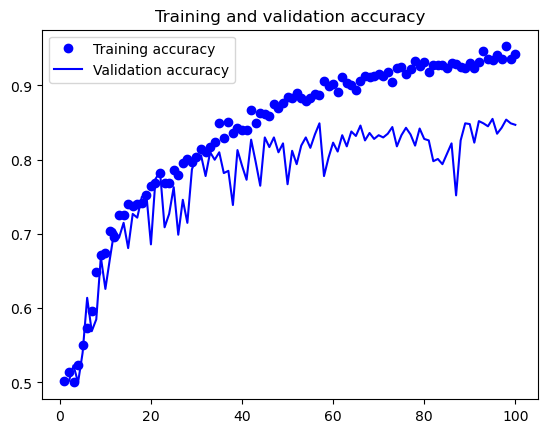

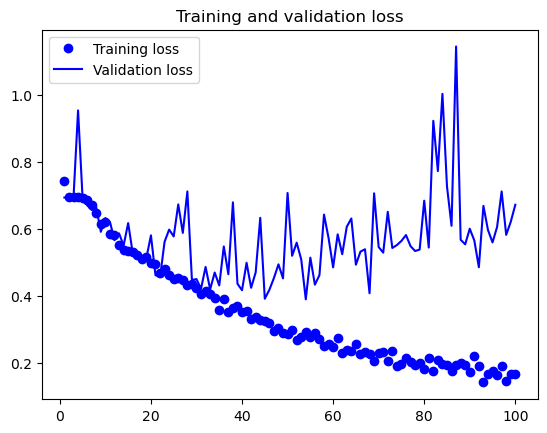

In [28]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

테스트셋에 대한 성능은 83% 정도로 올라갔다.

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 51ms/step - loss: 0.4976 - accuracy: 0.8265
Test accuracy: 0.826


`Conv2D`와 `MaxPooling2D` 층을 더 쌓거나 층에 사용된 필터수를 늘리는 방식으로
모델의 성능을 90% 정도까지 끌어올릴 수는 있지만 그 이상은 어려울 것이다.

**참고**

`convnet_from_scratch_with_augmentation` 모델을 
나중에 재활용하고자 한다. 이를 위해 구글 코랩을 사용하는 경우 모델을 저장해 두어야 한다.

## 8.3 모델 재활용

### 8.3.1. 전이 학습

아래 코드는 VGG16 합성곱 모델에서 밀집층(dense 층)을 제외한 나머지 합성곱 층으로만 이루어진 모델을 가져온다.

- `weights="imagenet"`: Imagenet 데이터셋으로 훈련된 모델
- `include_top=False`: 출력값을 결정하는 밀집 층 제외
- `input_shape=(180, 180, 3)`: 앞서 준비내 놓은 데이터셋 활용 가능하게 만들기

In [29]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
#     include_top=False,
#     input_shape=(180, 180, 3)
)

553467096/553467096 [==============================] - 160s 0us/step


가져온 모델을 요약하면 다음과 같다.

In [30]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**특성 추출**

**1) 단순 특성 추출**

아래 `get_features_and_labels()` 함수는 
`conv_base` 모델의 `predict()` 메서드를 이용하여 
준비된 훈련 데이터셋을 변환한다.
즉 모델 예측에 유용한 특성들로 구성된 데이터로 변환한다.
단, 레이블(타깃)은 그대로 둔다.

- `keras.applications.vgg16.preprocess_input()` 함수: `tf.float32` 자료형으로의 형변환 담당. 일종의 리스케일링 함수.

In [31]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    # 배치 단위로 VGG16 모델 적용
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
        
    # 생성된 배치를 하나의 텐서로 묶어서 반환
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


예를 들어, 변환된 강아지/고양이 이미지 샘플 2,000개는 이제 각각 `(5, 5, 512)` 모양을 갖는다.

In [36]:
train_features.shape

(2000, 5, 5, 512)

변환된 데이터셋을 훈련 데이터셋으로 사용하는 
간단한 분류 모델을 구성하여 훈련만 하면 된다.

In [40]:
# 입력층
inputs = keras.Input(shape=(5, 5, 512))

# 은닉층
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델
model = keras.Model(inputs, outputs)

검증셋에 대한 정확도가 97% 정도까지 향상된다.

In [41]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
62/63 [============================>.] - ETA: 0s - loss: 15.9682 - accuracy: 0.9279INFO:tensorflow:Assets written to: feature_extraction/assets


INFO:tensorflow:Assets written to: feature_extraction/assets


63/63 [==============================] - 5s 28ms/step - loss: 15.8405 - accuracy: 0.9285 - val_loss: 3.4298 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 4.4095 - accuracy: 0.9750 - val_loss: 4.6578 - val_accuracy: 0.9710
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2.1454 - accuracy: 0.9805 - val_loss: 4.6899 - val_accuracy: 0.9660
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 0.8724 - accuracy: 0.9920 - val_loss: 8.3850 - val_accuracy: 0.9570
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 0.8021 - accuracy: 0.9935 - val_loss: 7.0258 - val_accuracy: 0.9640
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 0.9184 - accuracy: 0.9935 - val_loss: 5.5283 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.2706 - accuracy: 0.9960 - val_loss: 6.7177 - val_accuracy: 0.9710
Epoch 8/20
63/63 [===========

훈련 결과를 시각화하면 다음과 같으며,
과대적합이 매우 빠르게 발생함을 확인할 수 있다.
데이터셋의 크기가 너무 작기 때문이며 데이터 증식 기법을 활용할
필요가 있음을 의미한다.

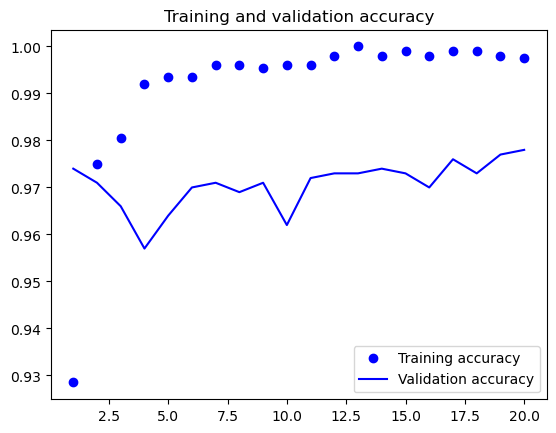

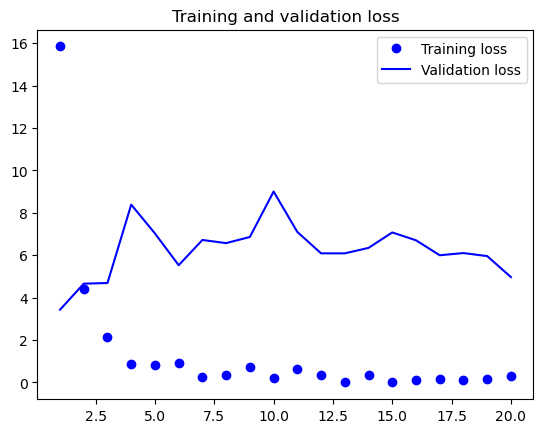

In [42]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**2) 데이터 증식과 특성 추출**

데이터 증식 기법을 활용하려면 
VGG16 합성곱 기저(베이스)를 구성요소로 사용하는 모델을 직접 정의해야 한다. 
다만 앞서 설명한 방식과는 달리 가져온 VGG16 기저에 포함된 파라미터가 새로운
모델의 훈련 과정동안 함께 훈련되지 않도록 설정해야 함에 주의해야 한다. 
이런 설정을 **동결**(freezing)이라 한다.

- 기저 동결하기: `trainable=False`로 지정.
- 입력 데이터의 모양도 미리 지정하지 않음에 주의할 것.

In [43]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# 새로운 학습 금지 설정
conv_base.trainable = False

파라미터 학습이 진행되지 않도록 동결하였기에 학습 가능한 파라미터 수가 0으로 확인된다.

In [44]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

아래 모델은 데이터 증식을 위한 층과 VGG16 기저를 함께 이용하여 모델을 지정한다.

In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# 모델 구성
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)                      # 데이터 증식
x = keras.applications.vgg16.preprocess_input(x)   # VGG16 베이스
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x) # 출력층

model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

이렇게 훈련하면 재활용된 합성곱 기저에 속한 층은 학습하지 않으며
두 개의 밀집층에서만 파라미터 학습이 이뤄진다.

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
62/63 [============================>.] - ETA: 0s - loss: 19.5988 - accuracy: 0.8992INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 12s 168ms/step - loss: 19.9677 - accuracy: 0.8980 - val_loss: 4.5797 - val_accuracy: 0.9610
Epoch 2/50
62/63 [============================>.] - ETA: 0s - loss: 8.6459 - accuracy: 0.9400INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 11s 164ms/step - loss: 8.5768 - accuracy: 0.9405 - val_loss: 2.8223 - val_accuracy: 0.9740
Epoch 3/50
62/63 [============================>.] - ETA: 0s - loss: 5.1691 - accuracy: 0.9577INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 10s 158ms/step - loss: 5.1413 - accuracy: 0.9575 - val_loss: 2.5560 - val_accuracy: 0.9790
Epoch 4/50
63/63 [==============================] - 8s 114ms/step - loss: 4.7865 - accuracy: 0.9595 - val_loss: 3.4650 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 8s 116ms/step - loss: 4.1236 - accuracy: 0.9645 - val_loss: 8.9938 - val_accuracy: 0.9600
Epoch 6/50
63/63 [==============================] - 8s 114ms/step - loss: 3.5572 - accuracy: 0.9685 - val_loss: 3.6143 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 8s 114ms/step - loss: 3.9862 - accuracy: 0.9680 - val_loss: 4.8262 - val_accuracy: 0.9760
Epoch 8/50
63/63 [==============================] - 8s 114ms/step - loss: 2.9964 - accuracy: 0.9750 - val_loss: 5.0451 - val_accuracy: 0.9720
Epoch 9/50
63/63 [==============================] - 8s 114ms/step - loss: 2.9744 - accuracy: 0.9745 - val_loss: 7.1171 - val_accuracy: 0.9660
Epoch 10/50
63/6

INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 10s 158ms/step - loss: 1.1338 - accuracy: 0.9855 - val_loss: 2.5532 - val_accuracy: 0.9780
Epoch 27/50
63/63 [==============================] - 8s 114ms/step - loss: 1.6208 - accuracy: 0.9795 - val_loss: 3.3438 - val_accuracy: 0.9790
Epoch 28/50
63/63 [==============================] - 8s 114ms/step - loss: 1.1601 - accuracy: 0.9825 - val_loss: 4.7626 - val_accuracy: 0.9690
Epoch 29/50
62/63 [============================>.] - ETA: 0s - loss: 0.7200 - accuracy: 0.9884INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 11s 166ms/step - loss: 0.7408 - accuracy: 0.9880 - val_loss: 2.4708 - val_accuracy: 0.9780
Epoch 30/50
63/63 [==============================] - 8s 114ms/step - loss: 1.6691 - accuracy: 0.9780 - val_loss: 2.7389 - val_accuracy: 0.9790
Epoch 31/50
62/63 [============================>.] - ETA: 0s - loss: 0.7304 - accuracy: 0.9879INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 10s 159ms/step - loss: 0.7245 - accuracy: 0.9880 - val_loss: 2.3466 - val_accuracy: 0.9780
Epoch 32/50
62/63 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.9914INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 11s 165ms/step - loss: 0.5040 - accuracy: 0.9915 - val_loss: 2.2329 - val_accuracy: 0.9780
Epoch 33/50
62/63 [============================>.] - ETA: 0s - loss: 0.7856 - accuracy: 0.9844INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 10s 159ms/step - loss: 0.7793 - accuracy: 0.9845 - val_loss: 1.9042 - val_accuracy: 0.9810
Epoch 34/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6101 - accuracy: 0.9900 - val_loss: 2.5395 - val_accuracy: 0.9790
Epoch 35/50
63/63 [==============================] - 8s 115ms/step - loss: 0.5251 - accuracy: 0.9905 - val_loss: 2.9111 - val_accuracy: 0.9740
Epoch 36/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6340 - accuracy: 0.9880 - val_loss: 2.9855 - val_accuracy: 0.9760
Epoch 37/50
63/63 [==============================] - 8s 114ms/step - loss: 0.4712 - accuracy: 0.9905 - val_loss: 2.1827 - val_accuracy: 0.9820
Epoch 38/50
63/63 [==============================] - 8s 114ms/step - loss: 0.7660 - accuracy: 0.9895 - val_loss: 1.9499 - val_accuracy: 0.9790
Epoch 39/50
63/63 [==============================] - 8s 115ms/step - loss: 0.5347 - accuracy: 0.9875 - val_loss: 2.2370 - val_accuracy: 0.9830
Epoch 40/5

INFO:tensorflow:Assets written to: feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 10s 160ms/step - loss: 0.5792 - accuracy: 0.9890 - val_loss: 1.8770 - val_accuracy: 0.9810
Epoch 49/50
63/63 [==============================] - 8s 115ms/step - loss: 0.1841 - accuracy: 0.9955 - val_loss: 2.9432 - val_accuracy: 0.9770
Epoch 50/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6402 - accuracy: 0.9855 - val_loss: 3.3748 - val_accuracy: 0.9730


과대적합이 보다 늦게 이루어지며 성능도 향상되었다.

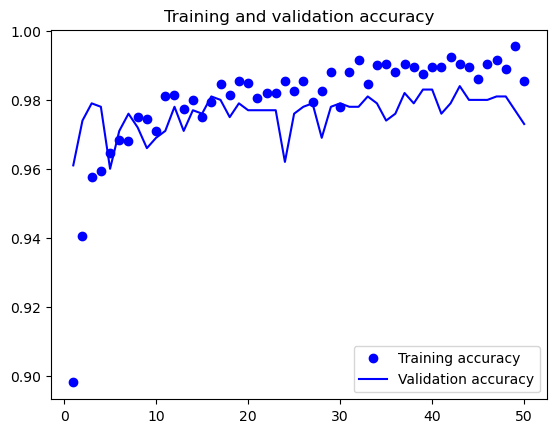

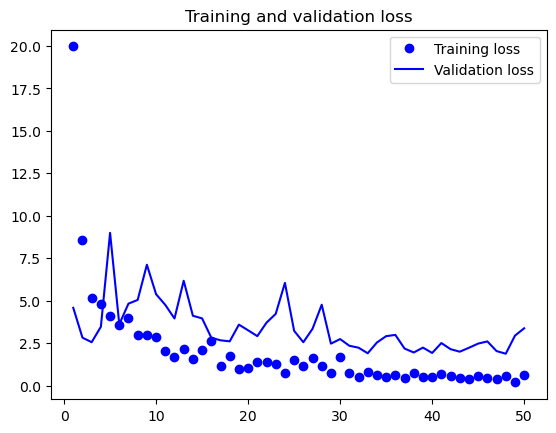

In [47]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

테스트셋에 대한 정확도가 97% 이상까지 향상된다.

In [48]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 68ms/step - loss: 2.6820 - accuracy: 0.9730
Test accuracy: 0.973


### 8.3.2. 모델 미세 조정

모델 **미세 조정**(파인 튜닝, fine-tuning)은 특성 추출 방식과는 달리
기존 합성곱 모델의 최상위 합성곱 층 몇 개를 동결 해제해서
새로운 모델에 맞추어 학습되도록 하는 모델 훈련기법이다.

여기서는 아래 그림에처럼 노락색 배경을 가진 상자 안에 포함된 합성곱 층을 
동결 해제해서 함께 학습되도록 한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-15.png" style="width:200px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

아래 코드는 모든 층에 대해 동결해제를 진행한 후에
마지막 4개 층을 제외한 나머지 층에 대해 다시 동결을 설정한다.

In [49]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

상위 4개 층만 동결 해제하는 이유는
합성곱 신경망의 하위층은 보다 일반적인 형태의 패턴을 학습하는 반면에
최상위층은 주어진 문제 해결에 특화된 패턴을 학습하기 때문이다.
따라서 이미지넷으로 훈련된 모델 전체를 대상으로 훈련하기 보다는
최상위층만 훈련시키는 것이 보다 유용하다.

모델 컴파일과 훈련 과정은 이전과 동일하게 진행한다.

In [50]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.9895INFO:tensorflow:Assets written to: fine_tuning/assets


INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 14s 163ms/step - loss: 0.4893 - accuracy: 0.9895 - val_loss: 2.2702 - val_accuracy: 0.9780
Epoch 2/30
63/63 [==============================] - 7s 109ms/step - loss: 0.4337 - accuracy: 0.9915 - val_loss: 2.5619 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 7s 108ms/step - loss: 0.2011 - accuracy: 0.9920 - val_loss: 3.4400 - val_accuracy: 0.9710
Epoch 4/30
62/63 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.9894INFO:tensorflow:Assets written to: fine_tuning/assets


INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 10s 154ms/step - loss: 0.4569 - accuracy: 0.9895 - val_loss: 1.9841 - val_accuracy: 0.9790
Epoch 5/30
62/63 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9975INFO:tensorflow:Assets written to: fine_tuning/assets


INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 11s 160ms/step - loss: 0.1656 - accuracy: 0.9975 - val_loss: 1.8960 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 7s 109ms/step - loss: 0.4974 - accuracy: 0.9900 - val_loss: 1.9689 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 7s 109ms/step - loss: 0.2239 - accuracy: 0.9935 - val_loss: 1.9407 - val_accuracy: 0.9790
Epoch 8/30
63/63 [==============================] - 7s 109ms/step - loss: 0.2376 - accuracy: 0.9925 - val_loss: 2.1692 - val_accuracy: 0.9790
Epoch 9/30
62/63 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9955INFO:tensorflow:Assets written to: fine_tuning/assets


INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 10s 159ms/step - loss: 0.1580 - accuracy: 0.9955 - val_loss: 1.8038 - val_accuracy: 0.9810
Epoch 10/30
63/63 [==============================] - 8s 113ms/step - loss: 0.2180 - accuracy: 0.9930 - val_loss: 1.9417 - val_accuracy: 0.9810
Epoch 11/30
62/63 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9955INFO:tensorflow:Assets written to: fine_tuning/assets


INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 11s 166ms/step - loss: 0.1726 - accuracy: 0.9950 - val_loss: 1.7027 - val_accuracy: 0.9830
Epoch 12/30
63/63 [==============================] - 8s 121ms/step - loss: 0.3223 - accuracy: 0.9935 - val_loss: 1.7320 - val_accuracy: 0.9830
Epoch 13/30
62/63 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9945INFO:tensorflow:Assets written to: fine_tuning/assets


INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 11s 173ms/step - loss: 0.2393 - accuracy: 0.9945 - val_loss: 1.4930 - val_accuracy: 0.9820
Epoch 14/30
63/63 [==============================] - 8s 118ms/step - loss: 0.2009 - accuracy: 0.9930 - val_loss: 2.4780 - val_accuracy: 0.9800
Epoch 15/30
63/63 [==============================] - 8s 116ms/step - loss: 0.1626 - accuracy: 0.9965 - val_loss: 1.8516 - val_accuracy: 0.9810
Epoch 16/30
63/63 [==============================] - 8s 116ms/step - loss: 0.1425 - accuracy: 0.9960 - val_loss: 1.6307 - val_accuracy: 0.9840
Epoch 17/30
63/63 [==============================] - 8s 115ms/step - loss: 0.1688 - accuracy: 0.9950 - val_loss: 1.8807 - val_accuracy: 0.9820
Epoch 18/30
63/63 [==============================] - 7s 111ms/step - loss: 0.0853 - accuracy: 0.9955 - val_loss: 1.7120 - val_accuracy: 0.9840
Epoch 19/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0695 - accuracy: 0.9965 - val_loss: 2.1282 - val_accuracy: 0.9800
Epoch 20/3

INFO:tensorflow:Assets written to: fine_tuning/assets


63/63 [==============================] - 10s 154ms/step - loss: 0.1821 - accuracy: 0.9970 - val_loss: 1.4268 - val_accuracy: 0.9830
Epoch 23/30
63/63 [==============================] - 7s 110ms/step - loss: 0.1444 - accuracy: 0.9955 - val_loss: 1.6406 - val_accuracy: 0.9830
Epoch 24/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0695 - accuracy: 0.9985 - val_loss: 2.0333 - val_accuracy: 0.9800
Epoch 25/30
63/63 [==============================] - 7s 108ms/step - loss: 0.1233 - accuracy: 0.9965 - val_loss: 1.6202 - val_accuracy: 0.9840
Epoch 26/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0972 - accuracy: 0.9975 - val_loss: 1.7155 - val_accuracy: 0.9810
Epoch 27/30
63/63 [==============================] - 7s 109ms/step - loss: 0.2000 - accuracy: 0.9945 - val_loss: 1.8512 - val_accuracy: 0.9810
Epoch 28/30
63/63 [==============================] - 7s 109ms/step - loss: 0.1346 - accuracy: 0.9950 - val_loss: 1.7717 - val_accuracy: 0.9830
Epoch 29/3

기존 모델을 재활용하여 98%($\pm\!$ 1%)에 육박하는 정확도 성능을 갖는
합성곱 신경망 모델을 2,0000개의 이미지만으로 학습시켰음을
확인할 수 있다.

In [51]:
model = keras.models.load_model("fine_tuning")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 67ms/step - loss: 1.9792 - accuracy: 0.9760
Test accuracy: 0.976
